In [151]:
import os, time 
from collections import OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc, rcParams
from linfitODR import linfit
from scipy.optimize import fmin
%matplotlib inline

#Style stuff:

rcParams.update({'errorbar.capsize': 0})
rc('text', usetex=True)
rc('font', size=11)
rc('legend', fontsize=11)
rcParams.update({'font.size':11})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

def load(usecols=None, saturated=False):
    trange = {'M44': [
                       (3e3,7e3,'o', 5e28, 5e36, 0.630),   
                       (3e3,3.249e3,'o', 5e28, 5e36, 0.630),
                       (3.25e3,3.499e3,'o', 5e28, 5e36, 0.630),
                       (3.5e3,3.749e3,'o', 5e28, 5e36, 0.630),
                       (3.75e3,4e3,'o', 5e28, 5e36, 0.630),
                     ],
#               'M44 - no binaries': [
#                        (3e3,7e3,'s', 5e28, 5e36, 0.630),   
#                        (3e3,3.249e3,'s', 5e28, 5e36, 0.630),
#                        (3.25e3,3.499e3,'s', 5e28, 5e36, 0.630),
#                        (3.5e3,3.749e3,'s', 5e28, 5e36, 0.630),
#                        (3.75e3,4e3,'s', 5e28, 5e36, 0.630),
#                      ],


         'Pleiades': [
                      (3e3,7e3,'v', 5e28, 5e36, 0.125),
                      (3e3,3.249e3,'v', 5e28, 5e36, 0.125),
                      (3.25e3,3.499e3,'v', 5e28, 5e36, 0.125),
                      (3.5e3,3.749e3,'v', 5e28, 5e36, 0.125),
                      (3.75e3,4e3,'v', 5e28, 5e36, 0.125),
                      ],}

    df = pd.DataFrame()
    loc = 'stars_shortlist/share/'
    for key in trange.keys():
         for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
            if key == 'M44 - no binaries':
                df2 = pd.read_csv('{}{}_{}_{}_{}_FFD_nobin.csv'.format(loc,test,key[:3],Tmin,Tmax),
                                 usecols=usecols)
                                  
                df2['nobin'] = True
                df2['clr'] = color
            else:
                df2 = pd.read_csv('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax),
                                 usecols=usecols)
                df2['nobin'] = False
                df2['clr'] = color

            df2['age'] = age
            df = df.append(df2)
    print(df.columns.values)
    if saturated == True:
        dft = pd.read_csv('{}run_06_saturated.csv'.format(loc),usecols=['EPIC','istart','istop','saturated'])

        print(df.shape,dft.shape)
        df = df.merge(dft, how='left',on=['EPIC','istart','istop'])
    return df

def linestyles(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:linestyles['densely dashed'], 
             3250:linestyles['densely dotted'],
             3500:linestyles['densely dashdotted'],
             3750:linestyles['densely dashdotdotted']}
        return c[Tmin]
    else: 
        return '-'

def markers(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:'o', 
             3250:'x',
             3500:'^',
             3750:'D'}
        return c[Tmin]
    else: 
        return '-'


def colorize(age):
    if age==0.125:
        return 'k'
    elif age == 0.63:
        return 'r'

def multicolorize(age):
    c = []
    for a in age:
        if a==0.125:
            c.append('k')
        elif a == 0.63:
            c.append('r')
    print(c)
    return c
    
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orangered'),
         (3500.0,3749.0,'gold'),(3750.0,4000.0,'c')]

In [152]:
df = load(saturated=True)
df.saturated.value_counts()

['Unnamed: 0' 'EPIC' 'Tmax' 'Tmin' 'alpha' 'alpha_err' 'beta' 'beta_err'
 'cluster' 'count_per_yr' 'high_yerr' 'istart' 'istop' 'logE' 'low_yerr'
 'maxenerg' 'n_obj' 'nflares' 'tobs' 'nobin' 'clr' 'age']
(1247, 22) (615, 4)


False    986
True     162
Name: saturated, dtype: int64

In [2]:
trange = {'M44': [
                   (3e3,7e3,'k', 5e28, 5e36, 0.630),   
                   (3e3,3.249e3,'red', 5e28, 5e36, 0.630),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36, 0.630),
                   (3.5e3,3.749e3,'green', 5e28, 5e36, 0.630),
                   (3.75e3,4e3,'c', 5e28, 5e36, 0.630),
                 ],

     'Pleiades': [
                  (3e3,7e3,'k', 5e28, 5e36, 0.125),
                  (3e3,3.249e3,'red', 5e28, 5e36, 0.125),
                  (3.25e3,3.499e3,'orange', 5e28, 5e36, 0.125),
                  (3.5e3,3.749e3,'green', 5e28, 5e36, 0.125),
                  (3.75e3,4e3,'c', 5e28, 5e36, 0.125),
                  ],}
df = pd.DataFrame()
loc = '/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/'
test = 'run_06'
for key in trange.keys():
    
    for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
        print('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax))
        df2 = pd.read_csv('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax),
                         usecols = ['Tmax','Tmin','alpha',
                                'alpha_err','beta','beta_err',
                                'maxenerg','n_obj','nflares',
                                   'cluster',])
        df2['age'] = age
        df = df.append(df2)
print(df.shape)
newres = df.drop_duplicates()
newres.alpha = -newres.alpha

/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3000.0_7000.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3000.0_3249.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3250.0_3499.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3500.0_3749.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3750.0_4000.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3000.0_7000.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3000.0_3249.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3250.0_3499.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3500.0_3749.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3750.0_4000.0_FFD.csv
(1247, 11)


/home/eilin/.local/lib/python3.4/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(1247, 17)
3249.0 (8, 17)
3249.0 (22, 17)
3499.0 (5, 17)
3499.0 (9, 17)
3749.0 (0, 17)
3749.0 (8, 17)
4000.0 (0, 17)
4000.0 (11, 17)
7000.0 (14, 17)
7000.0 (75, 17)


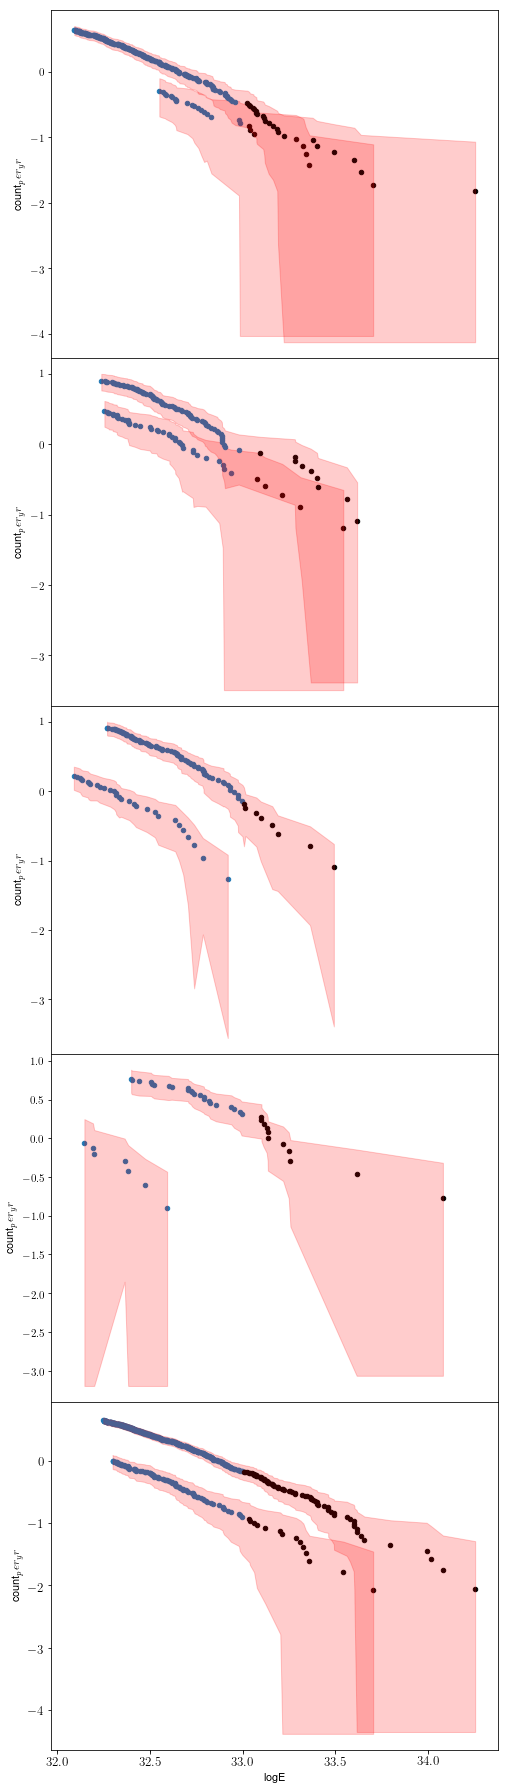

In [94]:
df = pd.DataFrame()
for key in trange.keys():
     for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
        df2 = pd.read_csv('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax))

        df2['age'] = age
        df = df.append(df2)
    
print(df.shape)    
fig, ax = plt.subplots(ncols=1, nrows=5,figsize=(8,32), sharex=True)
i=0
for name, g in df.groupby('Tmax'):
    for cluster, f in g.groupby('cluster'):
        f=f.sort_values(by='logE')
        f1 = f[f.logE<33]
        f2 = f[f.logE>33]
        print(name,f2.shape)
        f1.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i])
        if f2.shape[0] > 0:
            f2.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],color='black')
        ax[i].fill_between(f.logE, f.count_per_yr-f.low_yerr, f.count_per_yr+f.high_yerr,
                         alpha=0.2,color='r')
        
    i+=1
    

plt.tick_params(axis = 'both', labelsize = 13)

#plt.tight_layout()
plt.subplots_adjust(hspace=0)

In [95]:
def import_flares(cluster, test, oid):
    
    oid = int(float(oid))
    
    loc = 'stars_shortlist/{}/results/{}/results'.format(cluster,test)
    flux = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    flares = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])

    return flux, flares

def print_susp(oid, cluster, test):

    try:
        flux, flares = import_flares(cluster, test, oid)
        l = flares.shape[0]
        maxid = flux.shape[0]-1
        fig, ax = plt.subplots(ncols=l,nrows=1,figsize=(5*l,3.5))
        if l == 1:
            ax = [ax]
        
        for i, row in flares.iterrows():

            ax[i].plot(flux.time.iloc[row.istart-50:row.istop+50],
                     (flux.flux_gap-flux.flux_model).iloc[row.istart-50:row.istop+50],
                     linewidth=2,
                     color='green',)
            flare = (flux.flux_gap-flux.flux_model).iloc[row.istart:row.istop+1]
            ax[i].plot(flux.time.iloc[row.istart:row.istop+1],
                     flare,
                     linewidth=2,
                     color='red',)
            ax[i].set_xlim(flux.time.iloc[max(row.istart-50,0)],flux.time.iloc[min(row.istop+50,maxid)])
            ax[i].set_ylim(flare.min()*(-.2),flare.max()*1.1)
            ax[i].set_title('EPIC {}: {}-{}'.format(oid,row.istart,row.istop))
        plt.savefig('{}_highenerg'.format(oid),dpi=300)
        plt.close()
    except (FileNotFoundError, OSError):
        pass
    return


df = pd.DataFrame()
for key in trange.keys():
     for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
        if Tmax == 7000.:
            df2 = pd.read_csv('{}{}_{}_{}_{}_energs.csv'.format(loc,test,key,Tmin,Tmax))

            df2['age'] = age
            df = df.append(df2)
            

# for cluster in ['M44','Pleiades']:
    
#     flarelist = list(set(df[df.energ_true>3.1622776601683793e34].EPIC.tolist()))
#     for i in flarelist:
#         print_susp(i,cluster, test)

## Saturation investigation


In [153]:
from astropy.io import fits
dfsat = df.copy()
#dfsat = dfsat[dfsat.energ_true > 1e33]
flag = []
for i,row in dfsat.iterrows():
    epic = int(row.EPIC)
    try:
        hdul = fits.open('stars_shortlist/M44/ktwo{}-c05_lpd-targ.fits.gz'.format(epic))
    except:
        hdul = fits.open('stars_shortlist/Pleiades/ktwo{}-c04_lpd-targ.fits.gz'.format(epic))

    #plt.imshow(hdul[1].data['FLUX'][0])
    x = np.where(hdul[2].data == 3)
    maxfill = []
    ii = np.arange(-2,5)
    for j in ii:
        maxfill.append(max(hdul[1].data['FLUX'][int(row.istart)+j][x])/10093.)
    maxfill = np.asarray(maxfill)
    if maxfill.mean()>1: 
        flag.append(i)


In [154]:
df['saturated1'] = False
df.saturated1.loc[flag] = True
df.to_csv('stars_shortlist/share/run_06_saturated1.csv')

/home/eilin/.local/lib/python3.4/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Create table for paper

In [143]:
from astropy.io import fits
art = pd.read_csv('stars_shortlist/share/High_Energy_Flares/DropHighEnergy.csv')

def get(oid, cl='Pleiades',camp=4):
    alt = ('M44',5)
    fit = []
    try:
        hdu = fits.open('stars_shortlist/{}/hlsp_k2sc_k2_llc_{}-c0{}_kepler_v2_lc.fits'.format(cl,oid,camp))
    except:
        hdu = fits.open('stars_shortlist/{}/hlsp_k2sc_k2_llc_{}-c0{}_kepler_v2_lc.fits'.format(alt[0],oid,alt[1]))
    data_rec = hdu[1].data
    return pd.DataFrame({'time':np.array(data_rec['time']).byteswap().newbyteorder(),})

art['t_0']= art.apply(lambda x: get(x.EPIC).time[int(np.nan_to_num(x.istart))], axis=1)
art['t_f']= art.apply(lambda x: get(x.EPIC).time[int(np.nan_to_num(x.istop))], axis=1)
arts = art.copy()

In [144]:
arts = arts[arts.checkTPFifflare==0]
arts['t_0'][arts.istart.isnull()] = np.nan
arts['t_f'][arts.istop.isnull()] = np.nan
artss = arts[['EPIC','t_0','t_f','note']]
artss = artss.rename(index=str, columns={'t_0':'$t_0$',
                                         't_f':'$t_f$',})
artss = artss.sort_values('EPIC')
artss

,EPIC,$t_0$,$t_f$,note
29,210966700,2258.671619,2258.732914,flagged cadences
3,211038389,2251.643200,2251.867949,whole CCD flashes
4,211038389,2252.051835,2252.215290,no flares in LC
5,211060530,NaN,NaN,Bright CCD row
7,211066337,2279.471032,2279.532327,No brightening visible
8,211066337,2236.993468,2237.034332,No brightening visible
11,211089323,NaN,NaN,saturated
12,211091848,2243.245708,2243.286571,No brightening visible
13,211096368,2274.996528,2275.078254,Bright CCD row
15,211114329,2271.094166,2271.135030,No brightening visible


In [50]:
artss.to_latex('stars_shortlist/share/Paper/DropHighEnergy.tex',
            escape=False,col_space=10,index=False,na_rep='',column_format='cccc')